### Visual reasoning using `GPT4o` and 'OWLv2'
This code uses `MuJoCo` simulation with `OWLv2` and `GPT-4o`

In [1]:
import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
sys.path.append('../package/gpt_usage/')
sys.path.append('../package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


#### Parse `UR5e with objects`

In [2]:
xml_path = '../asset/makeup_frida/scene_table.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=True)
print ("Done.")

name:[Tabletop] dt:[0.002] HZ:[500]
n_qpos:[54] n_qvel:[48] n_qacc:[48] n_ctrl:[7]

n_body:[34]
 [0/34] [world] mass:[0.00]kg
 [1/34] [base_table] mass:[100.00]kg
 [2/34] [object_table] mass:[100.00]kg
 [3/34] [ur_base] mass:[4.00]kg
 [4/34] [ur_shoulder_link] mass:[3.70]kg
 [5/34] [ur_upper_arm_link] mass:[8.39]kg
 [6/34] [ur_forearm_link] mass:[2.27]kg
 [7/34] [ur_wrist_1_link] mass:[1.22]kg
 [8/34] [ur_wrist_2_link] mass:[1.22]kg
 [9/34] [ur_wrist_3_link] mass:[0.19]kg
 [10/34] [ur_tcp_link] mass:[0.00]kg
 [11/34] [ur_camera_mount] mass:[0.09]kg
 [12/34] [ur_d435i] mass:[0.07]kg
 [13/34] [ur_rg2_gripper_base_link] mass:[0.20]kg
 [14/34] [ur_camera_center] mass:[0.00]kg
 [15/34] [ur_rg2_gripper_finger1_finger_link] mass:[0.01]kg
 [16/34] [ur_rg2_gripper_finger1_inner_knuckle_link] mass:[0.01]kg
 [17/34] [ur_rg2_gripper_finger1_finger_tip_link] mass:[0.01]kg
 [18/34] [ur_rg2_gripper_finger2_finger_link] mass:[0.01]kg
 [19/34] [ur_rg2_gripper_finger2_inner_knuckle_link] mass:[0.01]kg
 

In [3]:
# Joint configuration
joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
               'wrist_1_joint','wrist_2_joint','wrist_3_joint']
print ("Ready.")

Ready.


In [4]:
# Solve IK to get the initial position 
env.reset()
env.set_p_body(body_name='ur_base',p=np.array([0,0,0.5])) # move UR
q_init,ik_err_stack,ik_info = solve_ik(
    env = env,
    joint_names_for_ik = joint_names,
    body_name_trgt     = 'ur_camera_center',
    q_init       = np.deg2rad([0,0,0,0,0,0]), # ik from zero pose
    p_trgt       = np.array([0.41,0.0,1.2]),
    R_trgt       = rpy2r(np.deg2rad([-135.22,-0.,-90])),
    max_ik_tick  = 5000,
    ik_err_th    = 1e-4,
    ik_stepsize  = 0.1,
    ik_eps       = 1e-2,
    ik_th        = np.radians(1.0),
    verbose      = False,
    reset_env    = False,
    render       = False,
    render_every = 1,
)
print ("Done.")

Done.


Object list:
 [0] obj_name:[obj_head]


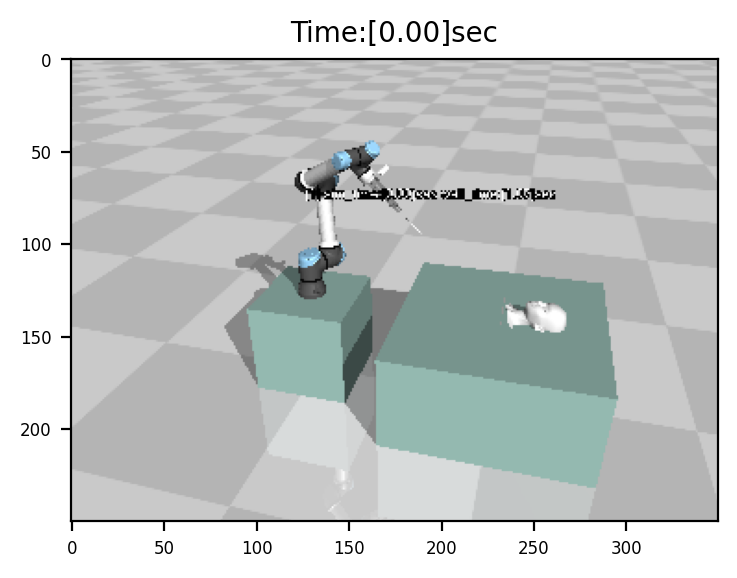

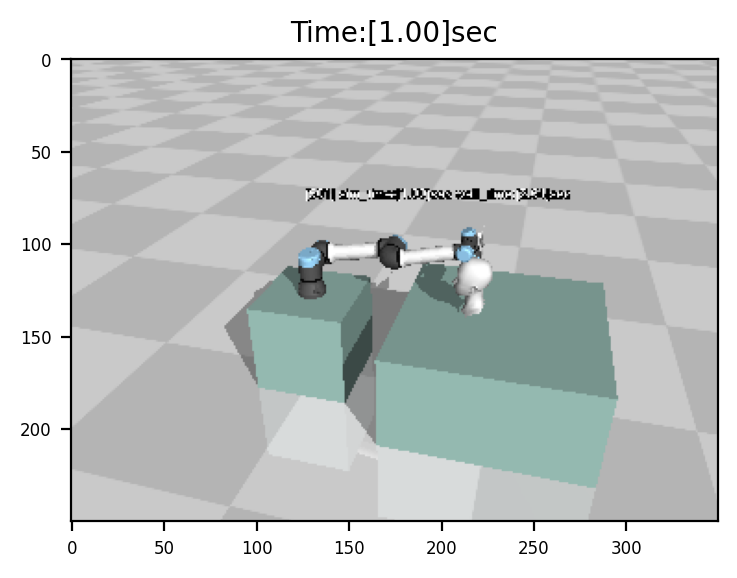

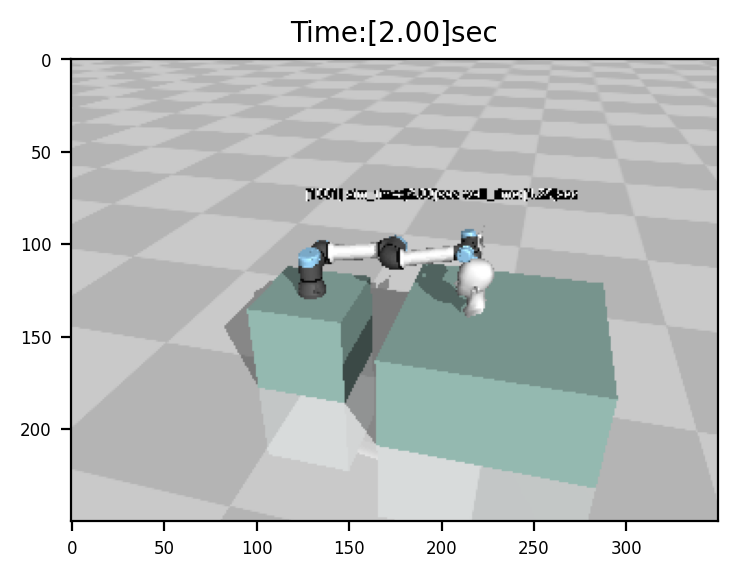

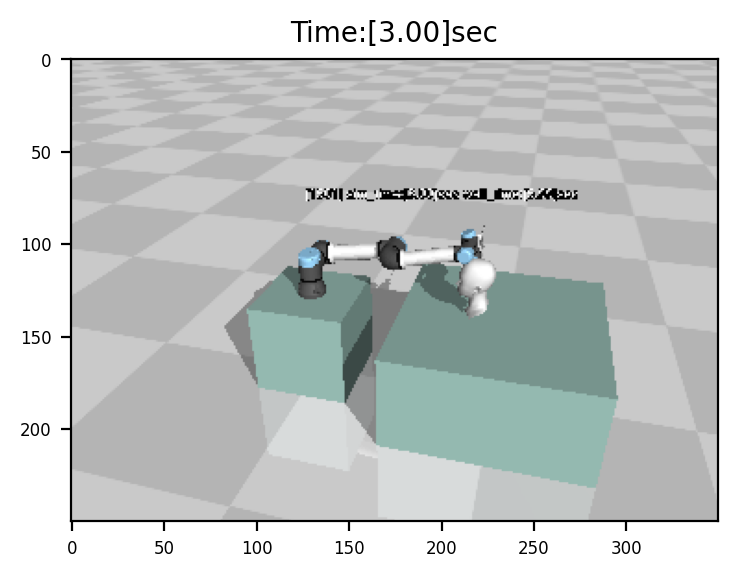

Done.


In [5]:
# Initialize environment

# Initialize viewer
env.reset()
env.init_viewer(
    transparent=False,
    azimuth=105,
    distance=3.12,
    elevation=-29,
    lookat=[0.39, 0.25, 0.43],
)

env.set_p_body(body_name='ur_base',p=np.array([0,0,0.5])) # move UR
env.set_p_body(body_name='object_table',p=np.array([1.0,0,0])) # move table
# obj_names = env.get_body_names(prefix='obj_') # object names
obj_names = ['obj_head']
n_obj = len(obj_names)
obj_xyzs = sample_xyzs(
    n_obj,
    x_range   = [0.75,1.25],
    y_range   = [-0.4,+0.4],
    z_range   = [0.51,0.51],
    min_dist  = 0.1,
    xy_margin = 0.0
)
obj_xyzs = np.array([[1, 0, 0.51]])
R = rpy2r(np.radians([0,0,270]))
print ("Object list:")
for obj_idx in range(n_obj):
    print (" [%d] obj_name:[%s]"%(obj_idx,obj_names[obj_idx]))
    env.set_p_base_body(body_name=obj_names[obj_idx],p=obj_xyzs[obj_idx,:])
    env.set_R_base_body(body_name=obj_names[obj_idx],R=R)
# Move
qpos = np.radians([0,-90,60,75,90,0])
idxs_step = env.get_idxs_step(joint_names=joint_names)
env.set_qpos_joints(joint_names=joint_names,qpos=q_init)

# Main loop
env_state = env.get_state()
while env.is_viewer_alive():
    # Step
    env.step()
    
    # Render
    if env.loop_every(tick_every=10):
        env.plot_time()
        env.render()
    
    # Plot
    if env.loop_every(tick_every=500):  # every 1 second
        # Grab current view
        render_img = env.grab_image(rsz_rate=1/4)
        # Plot
        plt.figure(figsize=(8, 3))
        plt.imshow(render_img)
        plt.title(f"Time:[{env.get_sim_time():.2f}]sec", fontsize=10)
        plt.show()
        

env.close_viewer()
print ("Done.")


#### Save the egocentric view `ego_rgb_img` as an image

In [6]:
import numpy as np
import os

def load_mesh_vertices(mesh_file_path):
    """
    Load vertices from an OBJ file
    """
    vertices = []
    
    with open(mesh_file_path, 'r') as f:
        for line in f:
            if line.startswith('v '):  # Vertex line
                parts = line.strip().split()
                if len(parts) >= 4:
                    x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                    vertices.append([x, y, z])
    
    return np.array(vertices)

def get_surface_points_from_mesh(env, body_name, mesh_file_path, num_points=10):
    """
    Get actual surface points from the mesh file
    """
    # Load mesh vertices
    mesh_vertices = load_mesh_vertices(mesh_file_path)
    
    # Get object pose
    obj_position, obj_rotation = env.get_pR_body(body_name=body_name)
    
    # Transform mesh vertices to world coordinates
    world_vertices = []
    for vertex in mesh_vertices:
        # Apply rotation and translation
        world_vertex = obj_rotation @ vertex + obj_position
        world_vertices.append(world_vertex)
    
    world_vertices = np.array(world_vertices)
    
    # Find surface points (vertices with maximum/minimum coordinates)
    surface_points = []
    
    # Front surface (maximum X)
    front_idx = np.argmax(world_vertices[:, 0])
    surface_points.append(world_vertices[front_idx])
    
    # Back surface (minimum X)
    back_idx = np.argmin(world_vertices[:, 0])
    surface_points.append(world_vertices[back_idx])
    
    # Right surface (maximum Y)
    right_idx = np.argmax(world_vertices[:, 1])
    surface_points.append(world_vertices[right_idx])
    
    # Left surface (minimum Y)
    left_idx = np.argmin(world_vertices[:, 1])
    surface_points.append(world_vertices[left_idx])
    
    # Top surface (maximum Z)
    top_idx = np.argmax(world_vertices[:, 2])
    surface_points.append(world_vertices[top_idx])
    
    # Bottom surface (minimum Z)
    bottom_idx = np.argmin(world_vertices[:, 2])
    surface_points.append(world_vertices[bottom_idx])
    
    return np.array(surface_points)

def get_surface_point_in_direction(env, body_name, mesh_file_path, direction):
    """
    Get the surface point in a specific direction from the object center
    """
    # Load mesh vertices
    mesh_vertices = load_mesh_vertices(mesh_file_path)
    
    # Get object pose
    obj_position, obj_rotation = env.get_pR_body(body_name=body_name)
    
    # Transform direction to object's local coordinate system
    local_direction = obj_rotation.T @ direction
    local_direction = local_direction / np.linalg.norm(local_direction)
    
    # Transform mesh vertices to local coordinates
    local_vertices = []
    for vertex in mesh_vertices:
        local_vertex = obj_rotation.T @ (vertex - obj_position)
        local_vertices.append(local_vertex)
    
    local_vertices = np.array(local_vertices)
    
    # Find the vertex that's furthest in the specified direction
    projections = local_vertices @ local_direction
    furthest_idx = np.argmax(projections)
    
    # Transform back to world coordinates
    surface_point = obj_rotation @ local_vertices[furthest_idx] + obj_position
    
    return surface_point

def plot_surface_dots_from_mesh(env, body_name, mesh_file_path):
    """
    Plot dots at actual surface points from the mesh
    """
    # Get surface points
    surface_points = get_surface_points_from_mesh(env, body_name, mesh_file_path)
    
    # Colors for different surface points
    colors = [
        [1, 0, 0, 0.8],  # Red - Front
        [0, 1, 0, 0.8],  # Green - Back
        [0, 0, 1, 0.8],  # Blue - Right
        [1, 1, 0, 0.8],  # Yellow - Left
        [1, 0, 1, 0.8],  # Magenta - Top
        [0, 1, 1, 0.8],  # Cyan - Bottom
    ]
    
    labels = ['Front', 'Back', 'Right', 'Left', 'Top', 'Bottom']
    
    # Plot each surface point
    for i, point in enumerate(surface_points):
        env.plot_sphere(
            p=point,
            r=0.01,
            rgba=colors[i],
            label=f'{labels[i]} Surface'
        )
        print(f"{labels[i]} surface point: {point}")

# Usage in your main loop
mesh_file_path = "asset/makeup_frida/mesh/head.obj"

while env.is_viewer_alive():
    env.step()
    
    # Render
    if env.loop_every(tick_every=10):
        env.plot_time()
        env.render()
        
        # Plot surface dots from actual mesh
        plot_surface_dots_from_mesh(env, 'obj_head', mesh_file_path)
        
        # Or get a specific surface point
        front_direction = np.array([1, 0, 0])
        front_surface_point = get_surface_point_in_direction(
            env, 'obj_head', mesh_file_path, front_direction
        )
        
        env.plot_sphere(
            p=front_surface_point,
            r=0.015,
            rgba=[1, 0, 0, 0.9],
            label='Front Surface (Exact)'
        )

#### Instantiate `GPT4o` agent

In [7]:
# Instantiate GPT4V helper
GPT = GPT4VchatClass(
    gpt_model = "gpt-4o", #"gpt-4-vision-preview",
    role_msg  = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
    key_path  = "../key/rilab_key.txt",
)
print ("Ready.")

key_path:[../key/rilab_key.txt]

FileNotFoundError: [Errno 2] No such file or directory: '../key/rilab_key.txt'

#### Ask `GPT4o` to describe the image

In [ ]:
# Plot
plt.figure(figsize=(6,4))
plt.imshow(ego_rgb_img)
plt.show()
# Describe the image
GPT.chat(
    user_msg = "<img1>Describe the image.",
    images   = [png_path],
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = False,
    MAX_TOKENS       = 512,
)
# List down the objects in the scene
ret = GPT.chat(
    user_msg = """
        Could you list down the object names suitable for detection in a json format? 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)
print ("Done.")

#### Run open-vocab detection (i.e., `Owlv2`) on the image

In [ ]:
# Parse object names
json_string = ret[ret.find('{'):ret.rfind('}')+1]
data = json.loads(json_string)
object_names = data['objects']
print ("object_names:%s"%(object_names))

# Open-vocab detection
owlvit = Owlv2()
detection_result = owlvit.detect_objects(
    image_path    = png_path,
    object_names  = object_names,
    box_threshold = 0.25,
)

# Plot detection results
plot_detection_result(
    image_path       = png_path,
    detection_result = detection_result,
    figsize          = (6,4),
    fontsize         = 5,
)

#### Get non-overlapping bounding boxes

In [ ]:
# Get pcd xyzs of objects
xyz_bboxes = []
for box in detection_result['boxes']: # for each detection boxes
    # First get xyz corresponding to the bbox
    x1,y1,x2,y2 = (box*xyz_img_world.shape[0]/ego_rgb_img.shape[0]).int()
    xyz = xyz_img_world[y1:y2+1,x1:x2+1,:].reshape((-1,3)) # [M x 3]
    xyz_bboxes.append(xyz) # append pcd xyz of bbox
# Exclude overlapping pcd
xyz_bboxes_unique = exclude_overlapping_pcd_within_list(xyz_bboxes)
# Get pcd xyz of objects and center of the objects    
xyz_objects,xyz_centers = [],[]
for xyz in xyz_bboxes_unique:
    # Get xyz of an object excluding the floor
    z_discretized = np.round(xyz[:,2]/0.01)*0.01 # discretized height [M]
    unique,counts = np.unique(z_discretized,return_counts=True)
    k = int(len(unique)*0.5) # for robust floor detection
    top_k_indices = np.argsort(counts)[-k:]
    top_k_unique_values = unique[top_k_indices]
    z_floor = np.min(top_k_unique_values)+0.005 # get z floor
    xyz_object = xyz[xyz[:,2] >= (z_floor)] # get xyz above the floor
    xyz_objects.append(xyz_object) # append pcd xyz above the floor
    # Now, get the center of the object in a xy plane
    xy_object = xyz_object[:,:2] # [M x 2]
    xy_center,radius = fit_xy_circle(xy_object) # center:[2]
    xyz_centers.append(np.append(xy_center,z_floor)) # [3]
print ("Done.")

#### Get object center points using point clouds

In [ ]:
env.reset()
env.set_state(**env_state)
env.init_viewer(azimuth=170,distance=2.3,elevation=-35,lookat=[0.01,0.1,-0.25],
                transparent=True,maxgeom=100000)
while env.is_viewer_alive():
    # Step
    env.step(ctrl=q_init,ctrl_idxs=idxs_step)
    # Render
    if env.loop_every(tick_every=10):
        for idx in range(detection_result['n']):
            env.plot_spheres(ps=xyz_bboxes[idx],r=0.002,rgba=(1,0,0,0.5))
            env.plot_spheres(ps=xyz_objects[idx],r=0.0025,rgba=(0,0,1,0.5))
            env.plot_T(p=xyz_centers[idx],R=np.eye(3),plot_axis=True,axis_len=0.15,axis_width=0.005)
            object_name = detection_result['object_names'][detection_result['labels'][idx]]
            env.plot_text(p=xyz_centers[idx]+np.array([0,0,0.15]),label='%s'%(object_name))
        env.render()
    # Plot
    if env.loop_every(tick_every=5000): # every 10 second
        # Grab current view
        render_img = env.grab_image(rsz_rate=1)
        # Plot
        plt.figure(figsize=(6,4))
        plt.imshow(render_img)
        plt.title("Time:[%.2f]sec"%(env.get_sim_time()),fontsize=10)
        plt.axis('off')
        plt.show()
env.close_viewer()
print ("Done.")

In [ ]:
# Store current GPT message
gpt_state = GPT.get_state()
print ("GPT state ready.")

#### Little bit of `common-sense` inference using `GPT4o`

In [ ]:
# Set GPT state
GPT.set_state(state=gpt_state)
ret = GPT.chat(
    user_msg = """
        Could you recommend one thing on the table that I can eat?
        BTW, I am very tired. It would be better if you can give me reasons as well.
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)